In [42]:
# Import libraries

from astropy.io import ascii
import astropy.coordinates as coord
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import EarthLocation, Angle, SkyCoord
from astropy.time import Time
from astropy.table import Table, unique
from funcs import *

In [43]:
# Set up times and locations

valid_dates = False
valid_times = False

# Check that dates and times are in the right order
while valid_dates == False:
    start_date = check_date('Please enter starting date of observation (YYYY-MM-DD): ')
    end_date = check_date('Please enter ending date of observation (YYYY-MM-DD): ')

    if (int(start_date[0:4]) > int(end_date[0:4])) or (int(start_date[0:4]) == int(end_date[0:4]) and int(start_date[5:7]) > int(end_date[5:7])) or (start_date[0:4] == end_date[0:4] and start_date[5:7] == end_date[5:7] and int(start_date[8:10]) > int(end_date[8:10])):
        print('End date must be the same or later than the start date')
    else:
        valid_dates = True

while valid_times == False:
    start_time = check_time('Please enter starting time of observation (HH:MM): ')
    end_time = check_time('Please enter ending time of observation (HH:MM): ')

    if start_date == end_date:
        if (start_time == end_time) or (int(start_time[0:2]) > int(end_time[0:2])) or (int(start_time[0:2]) == int(end_time[0:2]) and int(start_time[3:5]) > int(end_time[3:5])):
            print('End time must be later than the start time')
        else:
            valid_times = True
    else:
        valid_times = True


starting = start_date + ' ' + start_time
ending = end_date + ' ' + end_time

starting_time = Time(starting, scale='utc')
ending_time = Time(ending, scale='utc')

# Birr
birr_loc = EarthLocation(lat=53.095*u.deg, lon=-7.922*u.deg)

# Onsala
onsala_loc = EarthLocation(lat=57.399*u.deg, lon=11.930*u.deg)


# Midpoint
mid_lon = (birr_loc.lon + onsala_loc.lon) / 2
mid_lat = (birr_loc.lat + onsala_loc.lat) / 2
mid_loc = EarthLocation(lat=mid_lat, lon=mid_lon)
LST_start_mid = get_lst(mid_loc, starting)
LST_end_mid = get_lst(mid_loc, ending)

print('Starting LST at midpoint:', LST_start_mid)
get_lst(birr_loc, starting, 'Birr')
get_lst(onsala_loc, starting, 'Onsala')

print('\n')

print('Ending LST at midpoint:', LST_end_mid)
get_lst(birr_loc, ending, 'Birr')
get_lst(onsala_loc, ending, 'Onsala')

Starting LST at midpoint: 18h50m07.2138479s
The local siderial time at Birr at UTC: 2024-07-02 00:00 is: 18h10m24.97384791s
The local siderial time at Onsala at UTC: 2024-07-02 00:00 is: 19h29m49.4538479s


Ending LST at midpoint: 18h54m03.76994665s
The local siderial time at Birr at UTC: 2024-07-03 00:00 is: 18h14m21.52994665s
The local siderial time at Onsala at UTC: 2024-07-03 00:00 is: 19h33m46.00994664s


In [44]:
# Import data and clean it up

# Check what objects are to be observed
want_exo = want('exoplanets')
want_psr = want('pulsars independently')

# Exoplanet data
if want_exo == True:
    planets = check_file('Path to CSV file containing exoplanet hostname, coordinates and distances in NASA exoplanet database format: ', ['hostname', 'ra', 'dec', 'sy_dist'])

    # One planet per host
    planets = unique(planets, 'hostname')

    # Sort by distance
    planets.sort(keys='sy_dist')

    # The coordinates of the planets
    planets_ra = np.array(planets['ra'])
    planets_dec = np.array(planets['dec'])

    planets_coords = SkyCoord(ra=planets_ra, dec=planets_dec, unit='deg')

# Pulsar data
# Need to at least observe a pulsar once for calibration purposes
pulsars = check_file('Path to CSV file containing pulsar names, coordinates and luminosities in ATNF format: ', ['NAME', 'RAJ', 'DECJ', 'R_LUM'])

# Remove rows without luminosities
ind = pulsars['R_LUM'] != '*'
pulsars = pulsars[ind]

# Convert luminosities to floats
luminosities = np.array([])

for i in range(len(pulsars['R_LUM'])):
    base, exp = pulsars['R_LUM'][i].split('E')
    lum = float(base) * 10**float(exp)
    luminosities = np.append(luminosities, lum)

pulsars['R_LUM'] = luminosities

# The coordinates of the pulsars
psr_ra = np.array(pulsars['RAJ'])
psr_dec = np.array(pulsars['DECJ'])

psr_coords = SkyCoord(ra=psr_ra, dec=psr_dec, unit=(u.hourangle, u.deg))

In [45]:
# Pointing times

pointing_time_psr_cal = check_time('Time to spend observing a calibration pulsar (HH:MM): ')
pointing_time_psr_cal = (int(pointing_time_psr_cal[0:2])*u.hr + int(pointing_time_psr_cal[3:5])*u.min + 1*u.min).to(u.hr).value

if want_exo == True:
    # How long we'll point at a planet
    pointing_time_planet = check_time('Time to spend observing a planet (HH:MM): ')
    pointing_time_planet = (int(pointing_time_planet[0:2])*u.hr + int(pointing_time_planet[3:5])*u.min + 1*u.min).to(u.hr).value

    # Copy of planets that we can delete stuff from
    planets_copy = Table(planets, copy=True)

if want_psr == True:
    # How long we'll point at a planet
    pointing_time_psr = check_time('Time to spend observing a pulsar (HH:MM): ')
    pointing_time_psr = (int(pointing_time_psr[0:2])*u.hr + int(pointing_time_psr[3:5])*u.min + 1*u.min).to(u.hr).value

# Copy of pulsars that we can delete stuff from
pulsars_copy = Table(pulsars, copy=True)

In [46]:
# Optimise for closest to zenith at the middle of the observation window

time_LST = LST_start_mid.value
time_offset = 0
target_list = []
target_type = []

# How long from the start we will observe for
obs_time = (ending_time.mjd - starting_time.mjd) * 24 # hours

################################
# Calibration pulsar initially #
################################
mid_lst = (time_LST + pointing_time_psr_cal/2) * 15
zenith = SkyCoord(ra=mid_lst, dec=mid_lat, unit='deg')

sep = zenith.separation(psr_coords)
ind = np.argmin(sep)
target_list.append(pulsars_copy['NAME'][ind])

# Delete that index from the coordinates array and the copy table to prevent repeats
psr_coords = np.delete(psr_coords, ind)
pulsars_copy.remove_row(ind)

target_type.append('pulsar')

time_offset += pointing_time_psr_cal
time_LST += pointing_time_psr_cal

#########################
# Go for obs_time hours #
#########################
while time_offset <= obs_time:
    # Find the RA that is directly overhead in the middle of the observation window
    # Find target that is closest to the zenith at the middle of the observation window

    # Exoplanets
    if want_exo == True:
        mid_lst_planet = (time_LST + pointing_time_planet/2) * 15
        zenith_planet = SkyCoord(ra=mid_lst_planet, dec=mid_lat, unit='deg')
        sep_exo = zenith_planet.separation(planets_coords)
        ind_exo = np.argmin(sep_exo)
        sep_exo = sep_exo[ind_exo]
    else:
        sep_exo = np.inf

    # Pulsars
    if want_psr == True:
        mid_lst_psr = (time_LST + pointing_time_psr/2) * 15
        zenith_psr = SkyCoord(ra=mid_lst_psr, dec=mid_lat, unit='deg')
        sep_psr = zenith_psr.separation(psr_coords)
        ind_psr = np.argmin(sep_psr)
        sep_psr = sep_psr[ind_psr]
    else:
        sep_psr = np.inf

    # See which is closest to zenith
    if sep_exo < sep_psr:
        target_list.append(planets_copy['hostname'][ind_exo])

        # Delete that index from the coordinates array and the copy table to prevent repeats
        planets_coords = np.delete(planets_coords, ind_exo)
        planets_copy.remove_row(ind_exo)

        target_type.append('planet')
        
        # Move on
        time_offset += pointing_time_planet
        time_LST += pointing_time_planet
    else:
        target_list.append(pulsars_copy['NAME'][ind_psr])

        # Delete that index from the coordinates array and the copy table to prevent repeats
        psr_coords = np.delete(psr_coords, ind_psr)
        pulsars_copy.remove_row(ind_psr)

        target_type.append('pulsar')
        
        # Move on
        time_offset += pointing_time_psr
        time_LST += pointing_time_psr

# Output target list
print(target_list)

['B1839+56', 'HD 235088', 'B2045+56', 'B2036+53', 'TOI-1386', 'J2222+5602', 'B2306+55', 'B2255+58', 'B2319+60', 'B2324+60', 'B0037+56', 'TOI-3693', 'J0139+5621', 'TOI-3688 A', 'B0329+54', 'J0341+5711', 'B0355+54', 'B0353+52', 'B0450+55', 'J0417+61', 'TOI-3757', 'J0636+5128', 'J0645+5158', 'J0750+57', 'B0655+64', 'TOI-1728', 'TOI-3785', 'J1012+5307', 'TOI-1199', 'J1110+58', 'TOI-2068', 'TOI-1273', 'B1508+55', 'TOI-2048', 'TOI-2260', 'TOI-2180', 'TOI-2010']


Text(0.5, 1.0, 'Optimum observation windows with distance against RA of the exoplanets plotted')

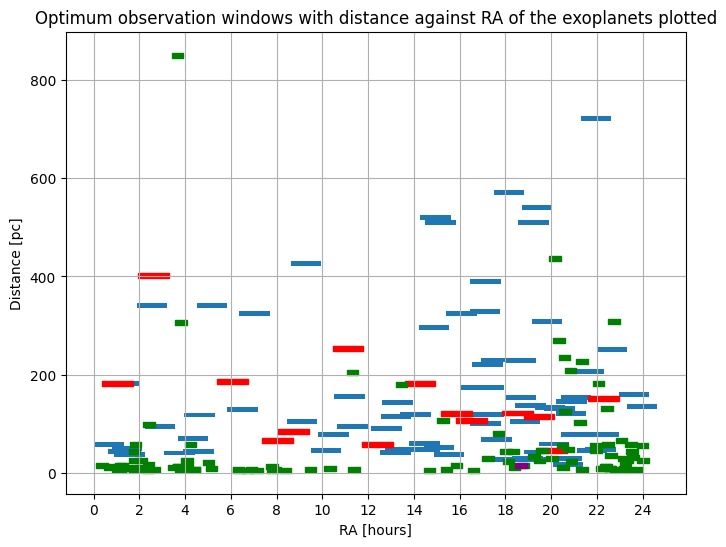

In [47]:
# Plot the optimum viewing windows for the targets
fig, ax = plt.subplots(figsize=(8,6))

# All planets
for i in range(len(planets['ra'])):
    # Plot from optimum start time of observation
    ax.broken_barh([(planets['ra'][i] - (pointing_time_planet - 1/60) * 7.5, (pointing_time_planet - 1/60) * 15)], (planets['sy_dist'][i], 10))

# Targeted planets in a different colour
for i in range(1, len(target_list)):
    index = planets['hostname'] == target_list[i]
    if sum(index) != 0:
        ind = np.argwhere(index)[0][0]

        # Plot from optimum start time of observation
        ax.broken_barh([(planets['ra'][ind] - (pointing_time_planet - 1/60) * 7.5, (pointing_time_planet - 1/60) * 15)], (planets['sy_dist'][ind], 10), color='red')
        #ax.text(planets['ra'][ind]+0.5 - 10, planets['sy_dist'][ind], planets['hostname'][ind])

# All pulsars
for i in range(len(pulsars['NAME'])):
    # Plot from optimum start time of observation
    try:
        ax.broken_barh([(Angle(psr_ra[i], u.hourangle).value * 15 - (pointing_time_psr - 1/60) * 7.5, (pointing_time_psr_cal - 1/60) * 15)], (pulsars['R_LUM'][i]/5, 10), color='green')
    except:
        ax.broken_barh([(Angle(psr_ra[i], u.hourangle).value * 15 - (pointing_time_psr_cal - 1/60) * 7.5, (pointing_time_psr_cal - 1/60) * 15)], (pulsars['R_LUM'][i]/5, 10), color='green')

# Calibration pulsar in a different colour
index = pulsars['NAME'] == target_list[0]
ind = np.argwhere(index)[0][0]

# Plot from optimum start time of observation
ax.broken_barh([(Angle(psr_ra[ind], u.hourangle).value * 15 - (pointing_time_psr_cal - 1/60) * 7.5, (pointing_time_psr_cal - 1/60) * 15)], (pulsars['R_LUM'][ind]/5, 10), color='purple')
        

ax.set_xticks(np.arange(0, 361, 30))
ax.set_xticklabels(np.arange(0, 25, 2))
ax.grid(True)
ax.set_xlabel('RA [hours]')
ax.set_ylabel('Distance [pc]')
ax.set_title('Optimum observation windows with distance against RA of the exoplanets plotted')


IndexError: index 0 is out of bounds for axis 0 with size 0

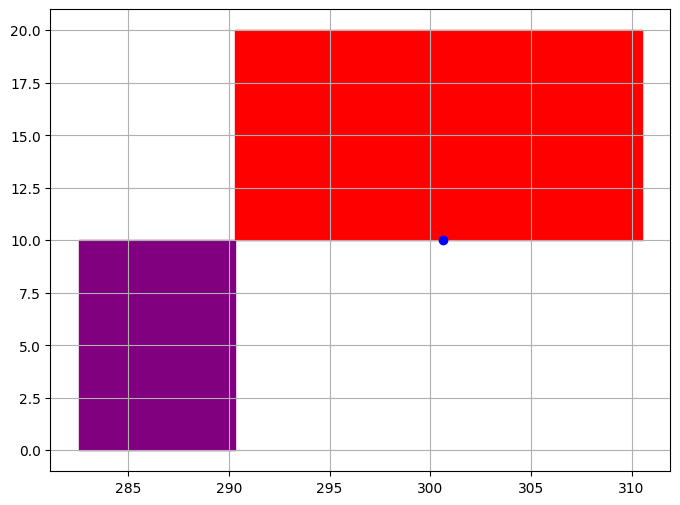

In [48]:
# Plot Actual viewing times
fig, ax = plt.subplots(figsize=(8,6))
ax.grid(True)

current_LST = LST_start_mid.value * 360/24

# Calibration pulsar in a different colour
index = pulsars['NAME'] == target_list[0]
ind = np.argwhere(index)[0][0]

# Plot from optimum start time of observation to +3.75 degrees (15 mins)
ax.broken_barh([(current_LST, pointing_time_psr_cal * 15)], (0, 10), color='purple')

current_LST += pointing_time_psr_cal * 15

for i in range(1, len(target_list)):
    # Plot from start time of observation to +20 degrees (1 hr 20 mins)
    index = planets['hostname'] == target_list[i]
    ind = np.argwhere(index)[0][0]

    # Plot at [len of planet observation * no planets already observed in hours + the initial offset as not starting from 0 + offset from ]
    ax.broken_barh([((current_LST) % 360, (pointing_time_planet * 15))], (i*10, 10), color='red')
    #ax.text(pointing_time_planet * i * 15 + start_deg, planets['sy_dist'][ind], planets['hostname'][ind])
    ax.plot(planets['ra'][ind], i*10, 'bo')

    current_LST += pointing_time_planet * 15
    current_LST %= 360

ax.set_xticks(np.arange(0, 361, 30))
ax.set_xticklabels(np.arange(0, 25, 2))
ax.set_xlabel('LST [hours]')
ax.set_ylabel('Distance [pc]')
ax.set_title('Scheduled time, LST against Distance of stars, blue dots - when the star reaches its zenith')



In [ ]:
# Output schedule with pointings and timings in iLiSA format

sched_iLiSA = Table(names=('Name', 'Time', 'RA', 'DEC'), dtype=(str, str, float, float))

time = starting_time.mjd

for i in range(len(target_list)):
    index = planets['hostname'] == target_list[i]
    ind = np.argwhere(index)[0][0]

    sched_iLiSA.add_row((planets['hostname'][ind], Time(time, format='mjd').iso[11:16], planets['ra'][ind]*u.deg.to(u.rad), planets['dec'][ind]*u.deg.to(u.rad)))

    # Wait the 1 hr 21 minutes
    time += pointing_time_planet/24     

# Take same frequency range for all observations

have_freq_range = False

while have_freq_range == False:

    try:
        min_freq = float(input('Please give the minimum frequency you\'d like to observe at (in MHz): '))
        max_freq = float(input('Please give the maximum frequency you\'d like to observe at (in MHz): '))
        have_freq_range = True
    except:
        print('Please enter a valid frequency')

freq_range = str(min_freq) + 'e6:' + str(max_freq) + 'e6'

sched_iLiSA['freqrng'] = freq_range

# Get the duration

dur = str(int(np.round((pointing_time_planet - 1/60) * 60))) + 'm'

sched_iLiSA['dur'] = dur

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
# Output schedule with pointings and timings in I-LOFAR format

sched_realta = Table(names=('start', '-', 'stop', ':', 'name', 'coords'), dtype=(str, str, str, str, str, str))

time = starting_time.mjd

for i in range(len(target_list)):
    index = planets['hostname'] == target_list[i]
    ind = np.argwhere(index)[0][0]

    end_time = time + (pointing_time_planet - 1/60)/24
    # Make sure the end tiem doesn't overshoot
    if end_time > ending_time.mjd:
        end_time = ending_time.mjd

    sched_realta.add_row((Time(time, format='mjd').iso, '-', Time(end_time, format='mjd').iso, ':', planets['hostname'][ind], f'[{planets['ra'][ind]*u.deg.to(u.rad)}, {planets['dec'][ind]*u.deg.to(u.rad)}, \'J2000\']'))

    # Wait the 1 hr 21 minutes
    time += pointing_time_planet/24     


In [ ]:
# Output files

ascii.write(sched_iLiSA, 'sched_iLiSA_temp.txt', overwrite=True)
ascii.write(sched_realta, 'sched_realta_temp.txt', overwrite=True)

# Need to remove the quotation marks
iLiSA = open('sched_iLiSA_temp.txt', 'r')
iLiSA_out = open('sched_iLiSA_out.txt', 'w')

rmv_quotes = iLiSA.read()
rmv_quotes = rmv_quotes.replace('"', '')

iLiSA_out.write(rmv_quotes)

realta = open('sched_realta_temp.txt', 'r')
realta_out = open('sched_realta_out.txt', 'w')

rmv_quotes = realta.read()
rmv_quotes = rmv_quotes.replace('"', '')

realta_out.write(rmv_quotes)

# Close the files
iLiSA.close()
iLiSA_out.close()

realta.close()
realta_out.close()